# **Overview of the Agent Graphs**


This tutorial is designed to guide you through the development of **two distinct agent graphs**, each tailored for specific scenarios:

## **Real-Data Agent Graph (Automated Weather Emergency):**
Focused on processing live, real-time weather data to ensure actionable and accurate insights during actual weather events.

## **Hybrid Agent Graph (Simulate of High Severity Weather level check with dummy weather and Social Monitoring data):**
Created for testing and simulation purposes, this graph combines real-time weather data with simulated weather scenarios to analyze behavior under extreme conditions without depending entirely on real-world events.

========================================================**Part 1** =================================================

## **Real-Data Agent Graph (Automated Weather Emergency):**

## **Overview**
This project demonstrates how to create an automated **Weather Emergency Response System** using **LangGraph**. The system monitors weather conditions, analyzes potential disasters, and generates emergency response plans. It integrates real-time weather data with generative AI for disaster analysis and response generation.

---

## **Motivation**
Efficient disaster response is crucial for minimizing damage and ensuring public safety. By leveraging automation and AI, this system aims to provide real-time weather monitoring and intelligent decision-making, streamlining emergency responses and reducing human error.

---

## **Key Components**

**State Management**

**Weather Data Retrieval**

**Disaster Analysis**

**Severity Analysis**

**Response Generation**

**Human Verification**

**Email Alerts**

**Data Logging**

**Workflow Graph**

---

## **Method Details**

### **Initialization**
- Sets up the environment and imports required libraries, including `requests` for API calls, `schedule` for periodic monitoring, and LangGraph for workflow management.

### **State Definition**
- Defines the structure of the workflow state, holding:
  - Weather data.
  - Disaster analysis results.
  - Severity levels.
  - Response plans.
  - Social media monitoring results.

### **Node Functions**
- Implements functions for each workflow step:
  - **Weather Data Retrieval**: Fetches or simulates weather data.
  - **Social Media Monitoring**: Analyzes social media reports for corroborative weather information.
  - **Disaster Analysis**: Identifies potential disasters using generative AI.
  - **Severity Assessment**: Determines the severity level of the disaster.
  - **Response Generation**: Prepares actionable emergency, civil defense, or public works plans.
  - **Email Notifications**: Sends alerts with disaster details and response plans.

### **Graph Construction**
- Constructs the workflow using **StateGraph**, defining nodes and edges to represent each process:
  - Nodes include data retrieval, analysis, response generation, and email alerts.
  - Conditional edges route workflows based on disaster severity and type.

### **Conditional Routing**
- Implements logic to:
  - Route disasters to appropriate response plans based on type and severity.
  - Handle human verification for low/medium severity events.

### **Workflow Compilation**
- Compiles the graph into an executable application, enabling real-time processing of weather data and automated decision-making.

### **Execution**
- Runs the system to monitor weather conditions for specified cities.
- Scheduled monitoring ensures continuous operation.

---

## Conclusion
This project showcases the power of **LangGraph** in creating AI-driven workflows for real-time disaster management. By combining automated data retrieval, generative AI analysis, and intelligent workflows, the system provides a robust framework for emergency response.

### Applications
- This approach can be extended to other domains, such as traffic management, supply chain monitoring, and environmental protection.
- With integration into existing emergency systems, it offers a scalable and customizable solution for various disaster management needs.










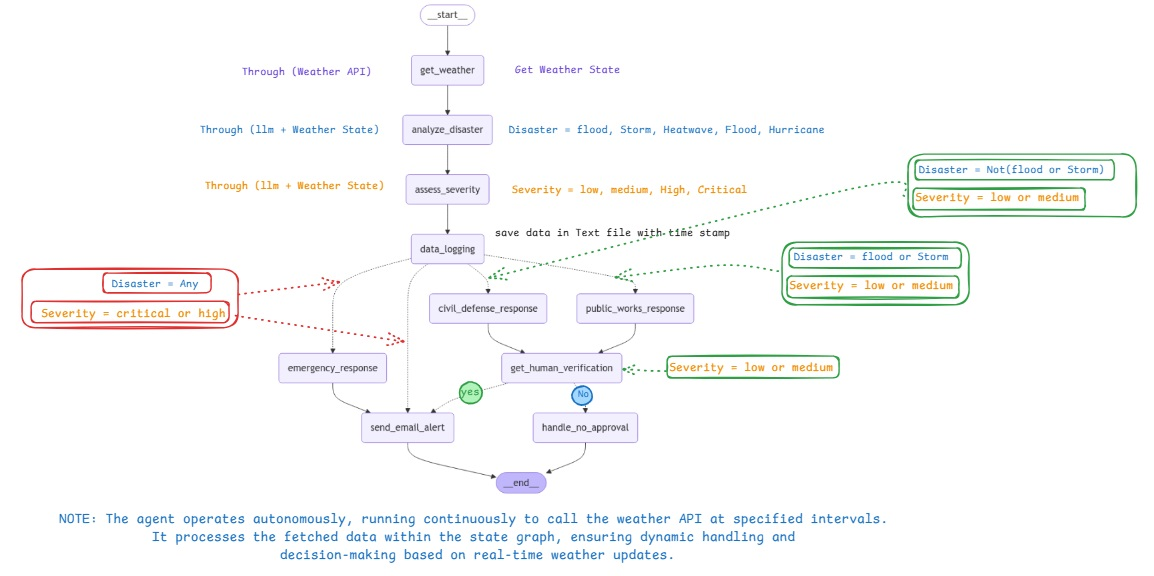

================================================**OK, let's start.**================================================

##  **1. Installation of Required Packages**



In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain langchain_google_genai langchain_community schedule

The `%%capture --no-stderr` command suppresses notebook cell outputs, including errors, helping to keep outputs clean during lengthy operations like `pip install`. The `%pip install -U` magic command installs and upgrades packages directly in notebooks. Key packages include **LangGraph**, **LangSmith**, **LangChain**, and integrations like **LangChain Google GenAI** and **LangChain Community**, along with **Schedule** for task scheduling.


## **2. Call Credentials and Set API Keys:**




In [ ]:
import os
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')
API_KEY = userdata.get('W_API_KEY')
os.environ["API_KEY"] = API_KEY
os.environ["GOOGLE_API_KEY"] = gemini_api_key

This code retrieves API keys (`GEMINI_API_KEY` and `W_API_KEY`) from Colab's userdata and sets them as environment variables. Use the following variable names exactly as shown (`GEMINI_API_KEY` & `W_API_KEY`) without changing them in Colab secret keys.


* GEMINI_API_KEY = ['Get and paste Your GEMINI API KEY'](https://ai.google.dev/gemini-api/docs/api-key)

* W_API_KEY = ['Get and paste Your Weather API KEY'](https://home.openweathermap.org/api_keys)


## **3. Standard Library Imports**

In [ ]:
import os
import random
import requests
import schedule
import time
from typing import Dict, TypedDict, Union, List, Literal
import json
from datetime import datetime
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

### **(a) Standard Library Imports**

- **`os`**: Manages environment variables securely (e.g., storing API keys).  
- **`random`**: Generates random numbers or selections for sampling or testing.  
- **`requests`**: Makes HTTP requests for fetching API data (e.g., weather).  
- **`schedule`**: Automates repetitive tasks like periodic data fetching.  
- **`time`**: Manages delays or time-based operations.  
- **`json`**: Parses and handles JSON data from APIs.  
- **`datetime`**: Handles date and time operations for timestamps or scheduling.

---

### **(b) Type Annotations from `typing`**

- **`Dict`, `TypedDict`, `Union`, `List`, `Literal`**: Improve readability and ensure structured data types.

---

### **(c) External Libraries**

- **`langgraph.graph.StateGraph`**: Manages workflows with state graphs.  
- **`langchain_core.prompts.ChatPromptTemplate`**: Structures inputs for LLMs.  
- **`langchain_google_genai.ChatGoogleGenerativeAI`**: Integrates Google Generative AI into workflows.  
- **`langchain_core.messages`**: Structures conversational messages (`AIMessage`, `HumanMessage`).

---

### **(d) Email Notification Libraries**

- **`smtplib`**: Sends emails via SMTP servers.  
- **`email.mime.text.MIMEText`**: Creates plain text email messages.  
- **`email.mime.multipart.MIMEMultipart`**: Includes text, HTML, or attachments in emails.

---



## **4. Defining an LLM and a State Class**

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

class WeatherState(TypedDict):
    city: str
    weather_data: Dict
    disaster_type: str
    severity: str
    response: str
    messages: List[Union[SystemMessage, HumanMessage, AIMessage]]
    alerts: List[str]
    human_approved: bool

**Standard Library Imports** handle various essential tasks: **`os`** for environment variables, **`requests`** for API calls, **`json`** for parsing data, and **`schedule`** for automation.  
**External Libraries** like **LangGraph** and **LangChain** enhance workflows, while **email.mime** and **smtplib** manage notifications.  
**Purpose**: Enables secure data handling, AI integration, and task automation with external APIs. **Use Cases** include disaster alerts, AI-driven agents, and scheduled reports.


## **5. Define Node Functions**



#### **(a) Fetching Weather Data**

In [ ]:
def get_weather_data(state: WeatherState) -> Dict:
    """Fetch weather data from OpenWeatherMap API"""
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    API_KEY = os.getenv("API_KEY")

    request_url = f"{BASE_URL}?appid={API_KEY}&q={state['city']}"
    try:
        response = requests.get(request_url)
        response.raise_for_status()

        data = response.json()
        weather_data = {
            "weather": data.get('weather', [{}])[0].get("description", "N/A"),
            "wind_speed": data.get("wind", {}).get("speed", "N/A"),
            "cloud_cover": data.get("clouds", {}).get("all", "N/A"),
            "sea_level": data.get("main", {}).get("sea_level", "N/A"),
            "temperature": round(data.get("main", {}).get("temp", 273.15) - 273.15, 1),
            "humidity": data.get("main", {}).get("humidity", "N/A"),
            "pressure": data.get("main", {}).get("pressure", "N/A")
        }

        return {
            **state,
            "weather_data": weather_data,
            "messages": state["messages"] + [SystemMessage(content=f"Weather data fetched successfully for {state['city']}")]
        }

    except Exception as e:
        error_data = {
            "weather": "N/A",
            "wind_speed": "N/A",
            "cloud_cover": "N/A",
            "sea_level": "N/A",
            "temperature": "N/A",
            "humidity": "N/A",
            "pressure": "N/A"
        }
        return {
            **state,
            "weather_data": error_data,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")]
        }


**The Weather Data Retrieval Script** fetches weather data using **OpenWeatherMap API** based on a city's name.  
It leverages **`requests`** for API integration, parses data into a structured format, and includes **error handling** for seamless operations, returning "N/A" for failures.  
This ensures reliability and organized data output for weather-based applications.


#### **(b) Disaster Type Analysis**

In [ ]:
def analyze_disaster_type(state: WeatherState) -> WeatherState:
    """Analyze weather data to identify potential disasters"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Based on the following weather conditions, identify if there's a potential weather disaster.\n"
        "Weather conditions:\n"
        "- Description: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "- Humidity: {humidity}%\n"
        "- Pressure: {pressure} hPa\n"
        "Categorize into one of these types: Hurricane, Flood, Heatwave, Severe Storm, Winter Storm, or No Immediate Threat"
    )

    try:
        chain = prompt | llm
        disaster_type = chain.invoke(weather_data).content
        return {
            **state,
            "disaster_type": disaster_type,
            "messages": state["messages"] + [SystemMessage(content=f"Disaster type identified: {disaster_type}")]
        }
    except Exception as e:
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to analyze disaster type: {str(e)}")]
        }

**Categorizing Weather Conditions** maps weather data to potential disaster types using a **template-based prompt** for analysis.  
It integrates **LLMs for intelligent decision-making** and ensures reliability through **error handling**, returning "Analysis Failed" in case of issues.  
This approach enhances disaster preparedness by leveraging AI insights.


#### **(c) Severity Assessment**

In [ ]:
def assess_severity(state: WeatherState) -> WeatherState:
    """Assess the severity of the identified weather situation"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Given the weather conditions and identified disaster type '{disaster_type}', "
        "assess the severity level. Consider:\n"
        "- Weather: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "Respond with either 'Critical', 'High', 'Medium', or 'Low'"
    )

    try:
        chain = prompt | llm
        severity = chain.invoke({
            **weather_data,
            "disaster_type": state["disaster_type"]
        }).content

        return {
            **state,
            "severity": severity,
            "messages": state["messages"] + [SystemMessage(content=f"Severity assessed as: {severity}")]
        }
    except Exception as e:
        return {
            **state,
            "severity": "Assessment Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to assess severity: {str(e)}")]
        }

**Determining Disaster Severity** assesses potential disasters by mapping `weather data to severity levels` like "Critical" or "High."  
It offers **actionable insights** for timely decision-making and includes **error handling** to ensure robust outputs in case of issues.  
This enhances response strategies by prioritizing critical events effectively.


#### **(d) Emergency Response Plan**

In [ ]:
def emergency_response(state: WeatherState) -> WeatherState:
    """Generate emergency response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create an emergency response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Include immediate actions needed."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Emergency response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate emergency response: {str(e)}")]
        }

**Emergency Response Creation** generates dynamic plans for high-severity disasters, prioritizing public safety.  
It leverages LLMs to craft customized and actionable response strategies effectively.


#### **(e) Civil Defense Response**

In [ ]:
def civil_defense_response(state: WeatherState) -> WeatherState:
    """Generate civil defense response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }

**Civil Defense Response Plan** generates safety-focused strategies using `ChatPromptTemplate` for disaster-specific queries.  
It ensures reliability through error handling, logging issues if the plan generation fails.


#### **(f) Public Works Response**

In [ ]:
def public_works_response(state: WeatherState) -> WeatherState:
    """Generate public works response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }

**Public Works Response Plan** focuses on protecting critical infrastructure during disasters.  
It tailors strategies for infrastructure challenges and updates the state with success messages upon plan completion.


#### **(g) Data Logging**

In [ ]:
def data_logging(state: WeatherState) -> WeatherState:
    """Log weather data, disaster analysis, and response to a file."""
    log_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "city": state["city"],
        "weather_data": state["weather_data"],
        "disaster_type": state["disaster_type"],
        "severity": state["severity"],
        "response": state["response"],
    }

    try:
        with open("disaster_log.txt", "a") as log_file:
            log_file.write(json.dumps(log_data) + "\n")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }

**Logging Weather Data** saves weather info, disaster analysis, and plans using `json.dumps` for structured storage.  
It includes error handling to ensure smooth logging without crashes.


#### **(h) Human Verification**

In [ ]:
def get_human_verification(state: WeatherState) -> WeatherState:
    """Get human verification for low/medium severity alerts"""
    severity = state["severity"].strip().lower()

    if severity in ["low", "medium"]:
        print("\n" + "="*50)
        print(f"Low/Medium severity alert for {state['city']} requires human approval:")
        print(f"Disaster Type: {state['disaster_type']}")
        print(f"Current Weather: {state['weather_data']['weather']}")
        print(f"Temperature: {state['weather_data']['temperature']}°C")
        print(f"Wind Speed: {state['weather_data']['wind_speed']} m/s")
        print(f"Severity: {state['severity']}")
        print(f"Response Plan: {state['response']}")
        print("\nType 'y' to approve sending alert or 'n' to reject (waiting for input):")
        print("="*50)

        # Block and wait for input
        while True:
            try:
                user_input = input().lower().strip()
                if user_input in ['y', 'n']:
                    approved = user_input == 'y'
                    print(f"Human verification result: {'Approved' if approved else 'Rejected'}")
                    break
                else:
                    print("Please enter 'y' for yes or 'n' for no:")
            except Exception as e:
                print(f"Error reading input: {str(e)}")
                print("Please try again with 'y' or 'n':")

        return {
            **state,
            "human_approved": approved,
            "messages": state["messages"] + [
                SystemMessage(content=f"Human verification: {'Approved' if approved else 'Rejected'}")
            ]
        }
    else:
        # Auto-approve for high/critical severity
        return {
            **state,
            "human_approved": True,
            "messages": state["messages"] + [
                SystemMessage(content=f"Auto-approved {severity} severity alert")
            ]
        }

**Logging Weather Data** saves weather info, disaster analysis, and plans using `json.dumps` for structured storage.  
It includes error handling to ensure smooth logging without crashes.

#### **(j) Email Alert**

In [ ]:
def send_email_alert(state: WeatherState) -> WeatherState:
    """Send weather alert email"""
    sender_email = os.getenv("SENDER_EMAIL")
    receiver_email = os.getenv("RECEIVER_EMAIL")
    password = os.getenv("EMAIL_PASSWORD")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = f"Weather Alert: {state['severity']} severity weather event in {state['city']}"

    body = format_weather_email(state)
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        text = msg.as_string()
        server.sendmail(sender_email, receiver_email, text)
        server.quit()

        # Add confirmation message
        severity = state["severity"].strip().lower()
        if severity in ["low", "medium"]:
            print(f"\nVerification was approved by human, Email sent to {receiver_email} successfully")
        else:
            print("\nEmail sent successfully for high severity alert")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Successfully sent weather alert email for {state['city']}")],
            "alerts": state["alerts"] + [f"Email alert sent: {datetime.now()}"]
        }

    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to send email alert: {str(e)}")]
        }

**Automated Email Alerts** send weather updates to stakeholders via SMTP, ensuring timely notifications.  
It features professional formatting for clear and actionable communication.


####  **(k) Handling No Approval**

In [ ]:
def handle_no_approval(state: WeatherState) -> WeatherState:
    """Handle cases where human verification was rejected"""
    print("\nVerification was not approved by human, Email not sent")

    message = (
        f"Alert not sent for {state['city']} - "
        f"Weather severity level '{state['severity']}' was deemed non-critical "
        f"by human operator and verification was rejected."
    )
    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=message)]
    }

**Alert Rejection Handling** logs rejection messages and updates the system state to reflect the operator's decision.  
Ensures clear tracking and acknowledgment of unapproved alerts.


####  **(l) Routing the Response**

In [ ]:
def route_response(state: WeatherState) -> Literal["emergency_response", "send_email_alert", "civil_defense_response", "public_works_response"]:
    """Route to appropriate department based on disaster type and severity"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    if severity in ["critical", "high"]:
        return "emergency_response"
        "send_email_alert"
    elif "flood" in disaster or "storm" in disaster:
        return "public_works_response"
    else:
        return "civil_defense_response"

**Response Department Routing** directs disasters based on type and severity:  
**Critical/high-severity** to emergency response, **floods/storms** to public works, and **others** to civil defense.


**(m) Approval Verification Router**

In [ ]:
def verify_approval_router(state: WeatherState) -> Literal["send_email_alert", "handle_no_approval"]:
    """Route based on human approval decision"""
    return "send_email_alert" if state['human_approved'] else "handle_no_approval"

**Next Step Decision** routes approved alerts to **email sending** and rejected ones to **rejection handling**, ensuring proper workflow.  
This simplifies decision-making based on human approval.


#### **(n) Formatting the Weather Email**

In [ ]:
def format_weather_email(state: WeatherState) -> str:
    """Format weather data and severity assessment into an email message"""
    weather_data = state["weather_data"]

    email_content = f"""
Weather Alert for {state['city']}

Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}

Current Weather Conditions:
- Weather Description: {weather_data['weather']}
- Temperature: {weather_data['temperature']}C
- Wind Speed: {weather_data['wind_speed']} m/s
- Humidity: {weather_data['humidity']}%
- Pressure: {weather_data['pressure']} hPa
- Cloud Cover: {weather_data['cloud_cover']}%

Response Plan:
{state['response']}

This is an automated weather alert generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    if state['severity'].lower() in ['low', 'medium']:
        email_content += "\nNote: This low/medium severity alert has been verified by a human operator."

    return email_content

**Weather Email Formatter** formats weather data and response details into a structured email alert.  
It includes weather conditions, disaster type, severity level, and the response plan, with additional notes for **low/medium severity** alerts.  
Ensures professional and comprehensive communication in automated alerts.


## **5. Creating and Compiling the Workflow**


In [ ]:
# Create the workflow
workflow = StateGraph(WeatherState)

# Add nodes
workflow.add_node("get_weather", get_weather_data)
workflow.add_node("analyze_disaster", analyze_disaster_type)
workflow.add_node("assess_severity", assess_severity)
workflow.add_node("data_logging", data_logging)
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("get_human_verification", get_human_verification)
workflow.add_node("send_email_alert", send_email_alert)
workflow.add_node("handle_no_approval", handle_no_approval)

# Add edges
workflow.add_edge("get_weather","analyze_disaster" )
workflow.add_edge("analyze_disaster", "assess_severity")
workflow.add_edge("assess_severity", "data_logging")
workflow.add_conditional_edges("data_logging", route_response)
workflow.add_edge("civil_defense_response", "get_human_verification")
workflow.add_edge("public_works_response", "get_human_verification")
workflow.add_conditional_edges("get_human_verification", verify_approval_router)
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("send_email_alert", END)
workflow.add_edge("handle_no_approval", END)

workflow.set_entry_point("get_weather")

# Compile the workflow
app = workflow.compile()

**Disaster Management Workflow** automates weather data retrieval, disaster analysis, and response coordination.  
It assesses disaster severity, logs results, and routes responses, integrating human approval for critical actions.  
Notifications are sent or rejections handled, ensuring smooth transitions and efficient disaster management.


##  **6 Running the Weather Emergency System**

This script automates a weather monitoring and disaster response system that can handle real-time updates, schedule periodic checks, and respond dynamically to emergencies for specified cities.

#### **(a) run_weather_emergency_system(city: str)**

In [ ]:
def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        print(f"Completed weather check for {city}")
        return result
    except Exception as e:
        print(f"Error running weather emergency system: {str(e)}")

**System Initialization** sets up weather monitoring by configuring `initial_state` for monitoring and response.  
The state is passed to `app.invoke()` for workflow execution, ensuring readiness for operations.


#### **(b) Main Function of the Weather Emergency Response System**




### **Note:** you can change below `City` and `Receiver email` with yours to check that Whether email notifications are working or not, Thanks

In [ ]:
def main():
    """Main function to run the weather emergency system"""
    # Set up environment variables
    os.environ["SENDER_EMAIL"] = "asif.ml.developer@gmail.com"  # Your email (don't change this please)
    os.environ["RECEIVER_EMAIL"] = "noor31fat10@gmail.com"  # Recipient email (you can give your email here to check)
    os.environ["EMAIL_PASSWORD"] = "iulr lsdb glfy pfbs"  # app password(don't change this please)

    def scheduled_check():
        """Function to perform scheduled checks for multiple cities"""
        cities = ['London', 'karachi']  # Add more cities as needed
        print(f"\nStarting scheduled check at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

        for city in cities:
            try:
                print(f"\nChecking weather conditions for {city}...")
                run_weather_emergency_system(city)
                time.sleep(2)  # Brief pause between cities
            except Exception as e:
                print(f"Error checking {city}: {str(e)}")

    # Schedule checks every hour
    schedule.every(1).minute.do(scheduled_check)
    print("Weather Emergency Response System started.")
    print("Monitoring scheduled for every minute.")

    while True:
        try:
            schedule.run_pending()
            time.sleep(1)
        except KeyboardInterrupt:
            print("\nShutting down Weather Emergency Response System...")
            break
        except Exception as e:
            print(f"Error in main loop: {str(e)}")
            time.sleep(1)

if __name__ == "__main__":
    main()

Weather Emergency Response System started.
Monitoring scheduled for every minute.

Starting scheduled check at 2024-11-24 17:50:28

Checking weather conditions for London...

Low/Medium severity alert for London requires human approval:
Disaster Type: No Immediate Threat.

While the wind speed is relatively high (10.8 m/s is around 24 mph, which could be considered breezy to windy), the other conditions (light rain, moderate temperature, and relatively normal pressure and humidity) don't indicate an imminent severe weather disaster like a hurricane, flood, heatwave, severe storm, or winter storm.  The wind speed alone isn't sufficient to categorize it as such.

Current Weather: light rain
Temperature: 16.6°C
Wind Speed: 10.8 m/s
Severity: Low

Response Plan: ## Public Works Response Plan: High Winds - London (No Immediate Threat - Low Severity)

**Incident:** Sustained high winds (10.8 m/s/24 mph) with light rain, moderate temperature, and normal pressure/humidity.

**Severity Level:**

**Main Function** initializes the Weather Emergency Response System, automating periodic checks and notifications.  
It sets up **email credentials**, schedules weather monitoring for cities like **London** and **Karachi**, and runs tasks every minute using `schedule`.  
With robust error handling, it ensures real-time monitoring and automated responses.

## **7. Visualize the Graph**

This cell generates and displays a visual representation of our LangGraph workflow.

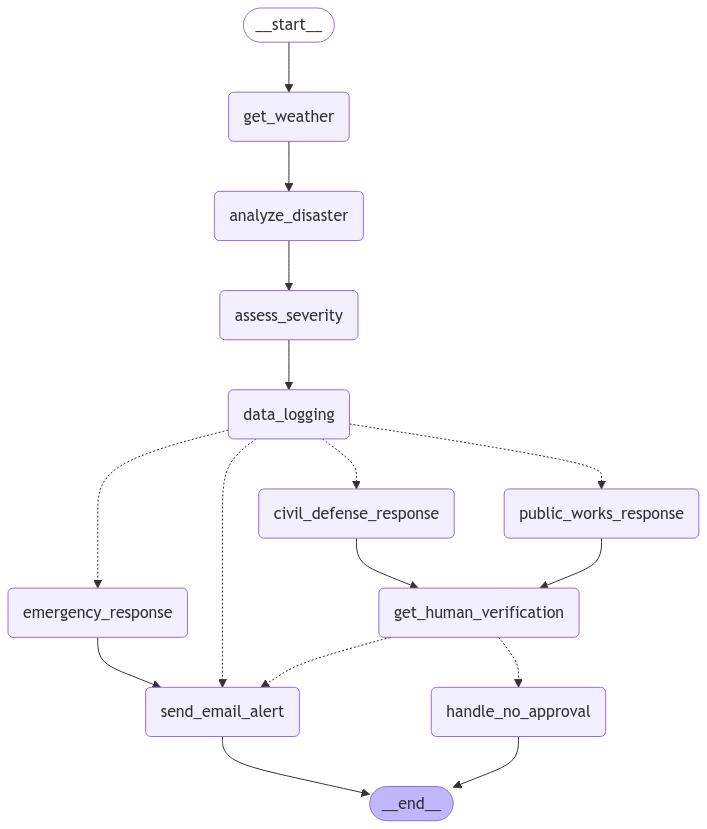

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

========================================================**Part 2** =================================================

## **Hybrid Agent Graph (Simulate High Severity Weather level check with dummy weather and Social Monitoring data):**


## **Note:** Below, only details are given for nodes or functions, which are not described above

================================================================================================================

##  **1. Installation of Required Packages**

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain langchain_google_genai langchain_community schedule

## **2. Call Credentials and Set API Keys:**

In [ ]:
import os
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')
API_KEY = userdata.get('W_API_KEY')
os.environ["API_KEY"] = API_KEY
os.environ["GOOGLE_API_KEY"] = gemini_api_key

## **3. Standard Library Imports**

In [ ]:
import os
import random
import requests
import schedule
import time
from typing import Dict, TypedDict, Union, List, Literal
import json
from datetime import datetime
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

## **4. Defining an LLM and a State Class**

In [ ]:
# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

class WeatherState(TypedDict):
    city: str
    weather_data: Dict
    disaster_type: str
    severity: str
    response: str
    messages: List[Union[SystemMessage, HumanMessage, AIMessage]]
    alerts: List[str]
    social_media_reports: List[str]
    human_approved: bool

## **5. Define Node Functions**

#### **(a) Fetching Weather Data**

In [ ]:
def get_weather_data(state: WeatherState) -> Dict:
    """Fetch weather data from OpenWeatherMap API or use simulated data in test mode"""
    # Check if we're in test mode (indicated by pre-populated weather_data)
    if state['weather_data']:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Using simulated weather data for {state['city']}")]
        }

    # If not in test mode, fetch real data from API
    BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
    API_KEY = os.getenv("API_KEY")

    request_url = f"{BASE_URL}?appid={API_KEY}&q={state['city']}"
    try:
        response = requests.get(request_url)
        response.raise_for_status()

        data = response.json()
        weather_data = {
            "weather": data.get('weather', [{}])[0].get("description", "N/A"),
            "wind_speed": data.get("wind", {}).get("speed", "N/A"),
            "cloud_cover": data.get("clouds", {}).get("all", "N/A"),
            "sea_level": data.get("main", {}).get("sea_level", "N/A"),
            "temperature": round(data.get("main", {}).get("temp", 273.15) - 273.15, 1),
            "humidity": data.get("main", {}).get("humidity", "N/A"),
            "pressure": data.get("main", {}).get("pressure", "N/A")
        }

        return {
            **state,
            "weather_data": weather_data,
            "messages": state["messages"] + [SystemMessage(content=f"Weather data fetched successfully for {state['city']}")]
        }
    except Exception as e:
        error_data = {
            "weather": "N/A",
            "wind_speed": "N/A",
            "cloud_cover": "N/A",
            "sea_level": "N/A",
            "temperature": "N/A",
            "humidity": "N/A",
            "pressure": "N/A"
        }
        return {
            **state,
            "weather_data": error_data,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")]
        }

#### **(b) Social Media Monitoring**


In [ ]:
def social_media_monitoring(state: WeatherState) -> WeatherState:
    """Simulate monitoring social media for additional reports of the weather event."""
    simulated_reports = [
        "Local reports of rising water levels and minor flooding.",
        "High winds causing power outages in parts of the city.",
        "Citizens reporting high temperatures and increased heat discomfort.",
        "Social media reports indicate severe storm damage in local infrastructure.",
        "Reports of traffic disruptions due to heavy rain.",
        "No unusual social media reports related to the weather at this time."
    ]

    social_media_report = random.choice(simulated_reports)
    return {
        **state,
        "social_media_reports": state["social_media_reports"] + [social_media_report],
        "messages": state["messages"] + [SystemMessage(content=f"Social media report added: {social_media_report}")]
    }

**Simulating Social Media Monitoring**

**Function: `social_media_monitoring`**

---

### **Purpose**

Enhances the weather monitoring system by simulating the gathering of weather-related updates from social media platforms.

---

### **Key Features**

1. **Randomized Report Selection**
   - **Process**: Randomly selects a weather-related report from a predefined list of updates.
   - **Purpose**: Adds variety and external input simulation to the monitoring system.

2. **State Updates**
   - **Field**: Adds the selected report to the `social_media_reports` field in the system state.
   - **Purpose**: Keeps track of simulated external inputs for further processing or analysis.

3. **Message Logging**
   - **Field**: Logs the update in the `messages` field of the state.
   - **Purpose**: Provides a detailed record of received and processed social media updates.

---

### **System Enhancement**

- **Simulated External Inputs**: Incorporates pseudo-real-time updates to improve the system's situational awareness.
- **Comprehensive Monitoring**: Complements weather data from APIs with additional simulated insights for better decision-making.


#### **(c) Analyzing Disaster Type**


In [ ]:
def analyze_disaster_type(state: WeatherState) -> WeatherState:
    """Analyze weather data to identify potential disasters"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Based on the following weather conditions, identify if there's a potential weather disaster.\n"
        "Weather conditions:\n"
        "- Description: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "- Humidity: {humidity}%\n"
        "- Pressure: {pressure} hPa\n"
        "Categorize into one of these types: Hurricane, Flood, Heatwave, Severe Storm, Winter Storm, or No Immediate Threat"
    )

    try:
        chain = prompt | llm
        disaster_type = chain.invoke(weather_data).content
        return {
            **state,
            "disaster_type": disaster_type,
            "messages": state["messages"] + [SystemMessage(content=f"Disaster type identified: {disaster_type}")]
        }
    except Exception as e:
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to analyze disaster type: {str(e)}")]
        }

#### **(d) Assess Severity Level**


In [ ]:
def assess_severity(state: WeatherState) -> WeatherState:
    """Assess the severity of the identified weather situation"""
    weather_data = state["weather_data"]
    prompt = ChatPromptTemplate.from_template(
        "Given the weather conditions and identified disaster type '{disaster_type}', "
        "assess the severity level. Consider:\n"
        "- Weather: {weather}\n"
        "- Wind Speed: {wind_speed} m/s\n"
        "- Temperature: {temperature}°C\n"
        "Respond with either 'Critical', 'High', 'Medium', or 'Low'"
    )

    try:
        chain = prompt | llm
        severity = chain.invoke({
            **weather_data,
            "disaster_type": state["disaster_type"]
        }).content

        return {
            **state,
            "severity": severity,
            "messages": state["messages"] + [SystemMessage(content=f"Severity assessed as: {severity}")]
        }
    except Exception as e:
        return {
            **state,
            "severity": "Assessment Failed",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to assess severity: {str(e)}")]
        }

#### **(e) Emergency Response**

In [ ]:
def emergency_response(state: WeatherState) -> WeatherState:
    """Generate emergency response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create an emergency response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Include immediate actions needed."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Emergency response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate emergency response: {str(e)}")]
        }

#### **(f) Civil Defense Response**

In [ ]:
def civil_defense_response(state: WeatherState) -> WeatherState:
    """Generate civil defense response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }

#### **(g) Public Works Response**

In [ ]:
def public_works_response(state: WeatherState) -> WeatherState:
    """Generate public works response plan"""
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }

#### **(h) Data Logging**

In [ ]:
def data_logging(state: WeatherState) -> WeatherState:
    """Log weather data, disaster analysis, and response to a file."""
    log_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "city": state["city"],
        "weather_data": state["weather_data"],
        "disaster_type": state["disaster_type"],
        "severity": state["severity"],
        "response": state["response"],
        "social_media_reports": state["social_media_reports"]
    }

    try:
        with open("disaster_log.txt", "a") as log_file:
            log_file.write(json.dumps(log_data) + "\n")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }


#### **(j) Get Human Verification**

In [ ]:
def get_human_verification(state: WeatherState) -> WeatherState:
    """Get human verification for low/medium severity alerts"""
    severity = state["severity"].strip().lower()

    if severity in ["low", "medium"]:
        print("\n" + "="*50)
        print(f"Low/Medium severity alert for {state['city']} requires human approval:")
        print(f"Disaster Type: {state['disaster_type']}")
        print(f"Current Weather: {state['weather_data']['weather']}")
        print(f"Temperature: {state['weather_data']['temperature']}°C")
        print(f"Wind Speed: {state['weather_data']['wind_speed']} m/s")
        print(f"Severity: {state['severity']}")
        print(f"Response Plan: {state['response']}")
        print("\nType 'y' to approve sending alert or 'n' to reject (waiting for input):")
        print("="*50)

        # Block and wait for input
        while True:
            try:
                user_input = input().lower().strip()
                if user_input in ['y', 'n']:
                    approved = user_input == 'y'
                    print(f"Human verification result: {'Approved' if approved else 'Rejected'}")
                    break
                else:
                    print("Please enter 'y' for yes or 'n' for no:")
            except Exception as e:
                print(f"Error reading input: {str(e)}")
                print("Please try again with 'y' or 'n':")

        return {
            **state,
            "human_approved": approved,
            "messages": state["messages"] + [
                SystemMessage(content=f"Human verification: {'Approved' if approved else 'Rejected'}")
            ]
        }
    else:
        # Auto-approve for high/critical severity
        return {
            **state,
            "human_approved": True,
            "messages": state["messages"] + [
                SystemMessage(content=f"Auto-approved {severity} severity alert")
            ]
        }

#### **(k) Send Email Alert**

In [ ]:
def send_email_alert(state: WeatherState) -> WeatherState:
    """Send weather alert email"""
    sender_email = os.getenv("SENDER_EMAIL")
    receiver_email = os.getenv("RECEIVER_EMAIL")
    password = os.getenv("EMAIL_PASSWORD")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = f"Weather Alert: {state['severity']} severity weather event in {state['city']}"

    body = format_weather_email(state)
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        text = msg.as_string()
        server.sendmail(sender_email, receiver_email, text)
        server.quit()

        # Add confirmation message
        severity = state["severity"].strip().lower()
        if severity in ["low", "medium"]:
            print(f"\nVerification was approved by human, Email sent to {receiver_email} successfully")
        else:
            print(f"\nEmail sent successfully for high severity alert to {receiver_email}")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Successfully sent weather alert email for {state['city']}")],
            "alerts": state["alerts"] + [f"Email alert sent: {datetime.now()}"]
        }

    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to send email alert: {str(e)}")]
        }

#### **(l) Handle No Approval From Human**

In [ ]:
def handle_no_approval(state: WeatherState) -> WeatherState:
    """Handle cases where human verification was rejected"""
    print("\nVerification was not approved by human, Email not sent")

    message = (
        f"Alert not sent for {state['city']} - "
        f"Weather severity level '{state['severity']}' was deemed non-critical "
        f"by human operator and verification was rejected."
    )
    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=message)]
    }

#### **(m) Route Response for Disaster Type and Severity**

In [ ]:
def route_response(state: WeatherState) -> Literal["emergency_response", "send_email_alert", "civil_defense_response", "public_works_response"]:
    """Route to appropriate department based on disaster type and severity"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    if severity in ["critical", "high"]:
        return "emergency_response"
        return "send_email_alert"
    elif "flood" in disaster or "storm" in disaster:
        return "public_works_response"
    else:
        return "civil_defense_response"

#### **(n) Verify Approval Route after Human Verification**

In [ ]:
def verify_approval_router(state: WeatherState) -> Literal["send_email_alert", "handle_no_approval"]:
    """Route based on human approval decision"""
    return "send_email_alert" if state['human_approved'] else "handle_no_approval"

#### **(p) Format Weather Email**

In [ ]:
def format_weather_email(state: WeatherState) -> str:
    """Format weather data and severity assessment into an email message"""
    weather_data = state["weather_data"]
    social_media_reports = "\n".join(state["social_media_reports"])

    email_content = f"""
Weather Alert for {state['city']}

Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}

Current Weather Conditions:
- Weather Description: {weather_data['weather']}
- Temperature: {weather_data['temperature']}C
- Wind Speed: {weather_data['wind_speed']} m/s
- Humidity: {weather_data['humidity']}%
- Pressure: {weather_data['pressure']} hPa
- Cloud Cover: {weather_data['cloud_cover']}%


Response Plan:
{state['response']}

This is an automated weather alert generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    if state['severity'].lower() in ['low', 'medium']:
        email_content += "\nNote: This low/medium severity alert has been verified by a human operator."

    return email_content

## **5. Creating and Compiling the Workflow**

In [ ]:
# Create the workflow
workflow = StateGraph(WeatherState)

# Add nodes
workflow.add_node("get_weather", get_weather_data)
workflow.add_node("social_media_monitoring", social_media_monitoring)
workflow.add_node("analyze_disaster", analyze_disaster_type)
workflow.add_node("assess_severity", assess_severity)
workflow.add_node("data_logging", data_logging)
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("get_human_verification", get_human_verification)
workflow.add_node("send_email_alert", send_email_alert)
workflow.add_node("handle_no_approval", handle_no_approval)

# Add edges
workflow.add_edge("get_weather", "social_media_monitoring")
workflow.add_edge("social_media_monitoring", "analyze_disaster")
workflow.add_edge("analyze_disaster", "assess_severity")
workflow.add_edge("assess_severity", "data_logging")
workflow.add_conditional_edges("data_logging", route_response)

workflow.add_edge("civil_defense_response", "get_human_verification")
workflow.add_edge("public_works_response", "get_human_verification")
workflow.add_conditional_edges("get_human_verification", verify_approval_router)
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("send_email_alert", END)
workflow.add_edge("handle_no_approval", END)

workflow.set_entry_point("get_weather")

# Compile the workflow
app = workflow.compile()

##  **6 Running the Weather Emergency System**

#### **(a) run_weather_emergency_system(city: str):**


In [ ]:
def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        print(f"Completed weather check for {city}")
        return result
    except Exception as e:
        print(f"Error running weather emergency system: {str(e)}")

#### **(b) Get Simulated Weather Data:**

In [ ]:
def get_simulated_weather_data(scenario: str = "high") -> Dict:
    """Generate simulated weather data for testing different scenarios"""
    scenarios = {
        "high": {
            "weather": "severe thunderstorm with heavy rainfall and strong winds",
            "wind_speed": 32.5,  # Increased for high severity
            "cloud_cover": 95,
            "sea_level": 1015,
            "temperature": 35.5,  # Higher temperature
            "humidity": 90,
            "pressure": 960  # Low pressure indicating severe weather
        },
        "medium": {
            "weather": "moderate rain with gusty winds",
            "wind_speed": 15.2,
            "cloud_cover": 75,
            "sea_level": 1012,
            "temperature": 22.3,
            "humidity": 70,
            "pressure": 1005
        },
        "low": {
            "weather": "light drizzle",
            "wind_speed": 8.5,
            "cloud_cover": 45,
            "sea_level": 1013,
            "temperature": 20.1,
            "humidity": 60,
            "pressure": 1015
        }
    }

    return scenarios.get(scenario.lower(), scenarios["medium"])


#### **(c) Run Weather Emergency System Test**

In [ ]:
def run_weather_emergency_system_test(city: str, scenario: str = "high"):
    """Test the weather emergency system with simulated data"""
    # Pre-populate with simulated data
    initial_state = {
        "city": city,
        "weather_data": get_simulated_weather_data(scenario),
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        print(f"\nCompleted test weather check for {city} with {scenario} severity scenario")
        return result
    except Exception as e:
        print(f"Error running weather emergency system test: {str(e)}")



### **Purpose**

Tests the Weather Emergency System using simulated weather data to ensure workflow reliability and robustness.

---

### **Key Features**

(a) **Scenario-Based Testing**
   - **Input**: Accepts a predefined scenario (e.g., `"high"` severity).
   - **Data Simulation**: Uses `get_simulated_weather_data(scenario)` to initialize a test state with relevant simulated weather data.

(b) **Workflow Execution**
   - **Process**: Executes the workflow using `app.invoke` with the test state.
   - **Purpose**: Validates the system's functionality in handling the simulated scenario.

(c) **Result Logging**
   - **Logs**: Captures and records the results of the test run.
   - **Purpose**: Provides insights into system behavior and outcomes for debugging or evaluation.

(d) **Error Handling**
   - **Graceful Management**: Catches and manages errors during the test run.
   - **Purpose**: Ensures uninterrupted testing and meaningful error reports.

---

### **System Benefits**

- **Robustness Validation**: Ensures the system handles various scenarios effectively.
- **Simulated Environment**: Enables safe testing without impacting live data or workflows.
- **Error Detection**: Identifies and logs potential issues for resolution before deployment.
---





### **ScreenShots : which will guide how to run this program**

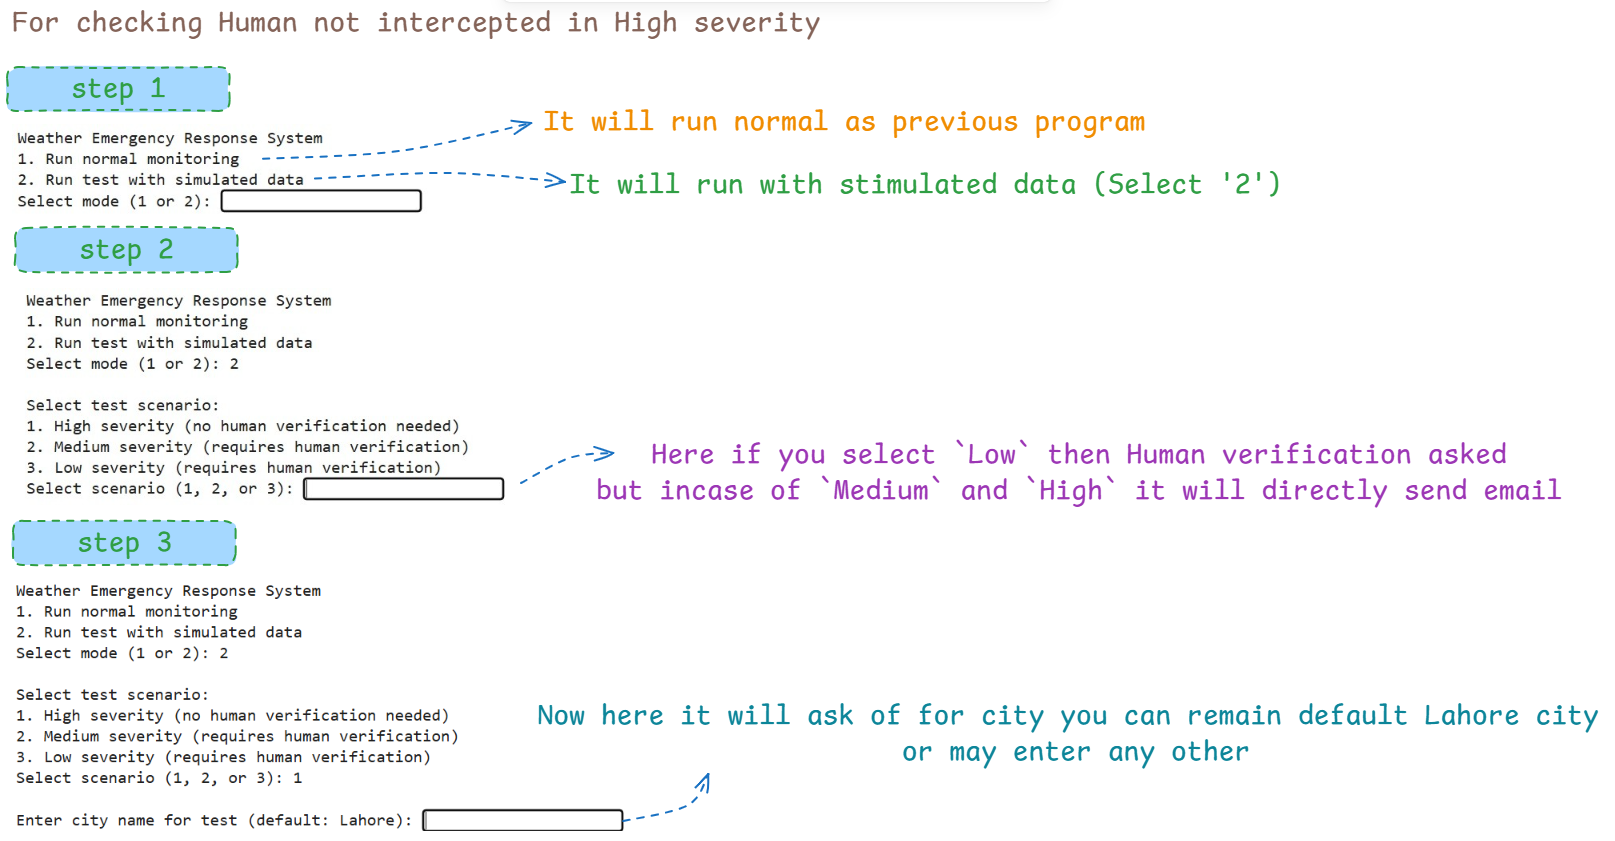

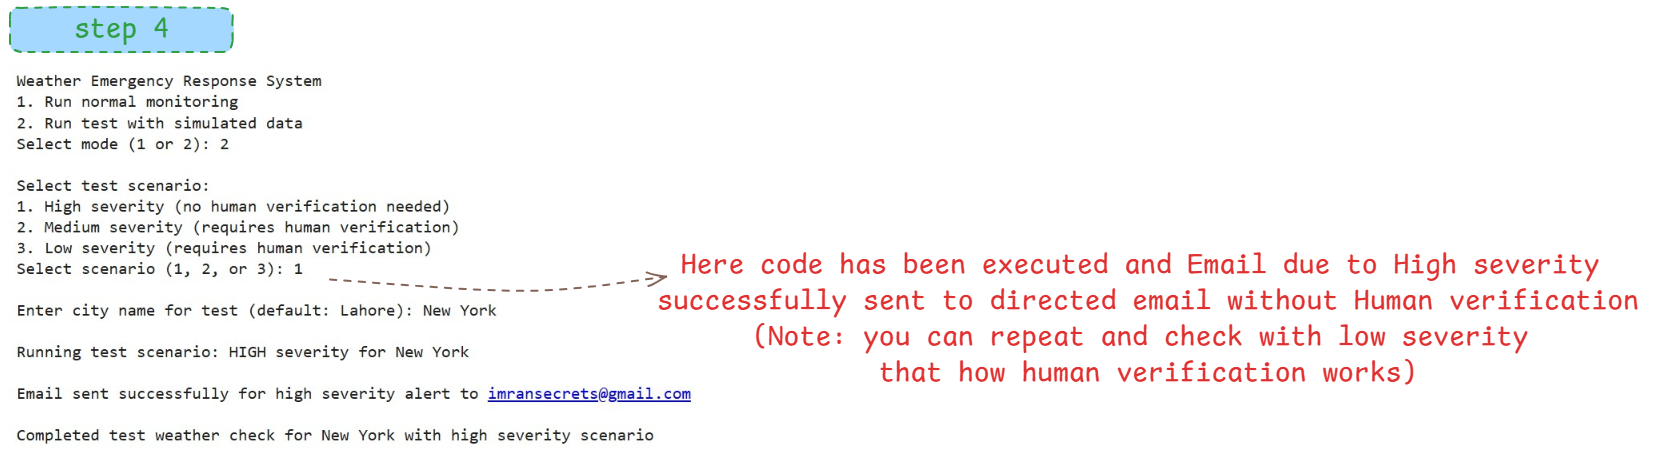

#### **(d) Run Main Function**

### **Note:** you can change or include cities and receiver emails with yours to check that Whether email notifications are working or not

In [ ]:
def main():
    """Main function to run the weather emergency system"""
    # Set up environment variables

    os.environ["SENDER_EMAIL"] = "asif.ml.developer@gmail.com"  # please no change this
    os.environ["RECEIVER_EMAIL"] = "imransecrets@gmail.com"  # Recipient email you can change and checked
    os.environ["EMAIL_PASSWORD"] = "iulr lsdb glfy pfbs"  # please no change this

    # Add test mode option
    print("\nWeather Emergency Response System")
    print("1. Run normal monitoring")
    print("2. Run test with simulated data")
    choice = input("Select mode (1 or 2): ")

    if choice == "2":
        print("\nSelect test scenario:")
        print("1. High severity (no human verification needed)")
        print("2. Medium severity (requires human verification)")
        print("3. Low severity (requires human verification)")

        scenario_choice = input("Select scenario (1, 2, or 3): ")
        scenario_map = {"1": "high", "2": "medium", "3": "low"}
        scenario = scenario_map.get(scenario_choice, "medium")

        city = input("\nEnter city name for test (default: Lahore): ").strip() or "Lahore"
        print(f"\nRunning test scenario: {scenario.upper()} severity for {city}")
        run_weather_emergency_system_test(city, scenario)
    else:
        def scheduled_check():
            """Function to perform scheduled checks for multiple cities"""
            cities = ['Lahore']  # Add more cities as needed
            print(f"\nStarting scheduled check at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

            for city in cities:
                try:
                    print(f"\nChecking weather conditions for {city}...")
                    run_weather_emergency_system(city)
                    time.sleep(2)  # Brief pause between cities
                except Exception as e:
                    print(f"Error checking {city}: {str(e)}")

        # Schedule checks every minut
        schedule.every(1).minute.do(scheduled_check)
        print("Weather Emergency Response System started.")
        print("Monitoring scheduled for every minute.")

        while True:
            try:
                schedule.run_pending()
                time.sleep(1)
            except KeyboardInterrupt:
                print("\nShutting down Weather Emergency Response System...")
                break
            except Exception as e:
                print(f"Error in main loop: {str(e)}")
                time.sleep(1)

if __name__ == "__main__":
    main()


Weather Emergency Response System
1. Run normal monitoring
2. Run test with simulated data
Select mode (1 or 2): 2

Select test scenario:
1. High severity (no human verification needed)
2. Medium severity (requires human verification)
3. Low severity (requires human verification)
Select scenario (1, 2, or 3): 1

Enter city name for test (default: Lahore): New York

Running test scenario: HIGH severity for New York

Email sent successfully for high severity alert to imransecrets@gmail.com

Completed test weather check for New York with high severity scenario


# **Note: In above code if you want to use:**

*   `Real Data` then choose option 1 (Here run code normal as above)
*   and if you want to `dummy simulated data` then choose 2 with `high severity` to check that when high severity is happen then email notification sent without human verification.




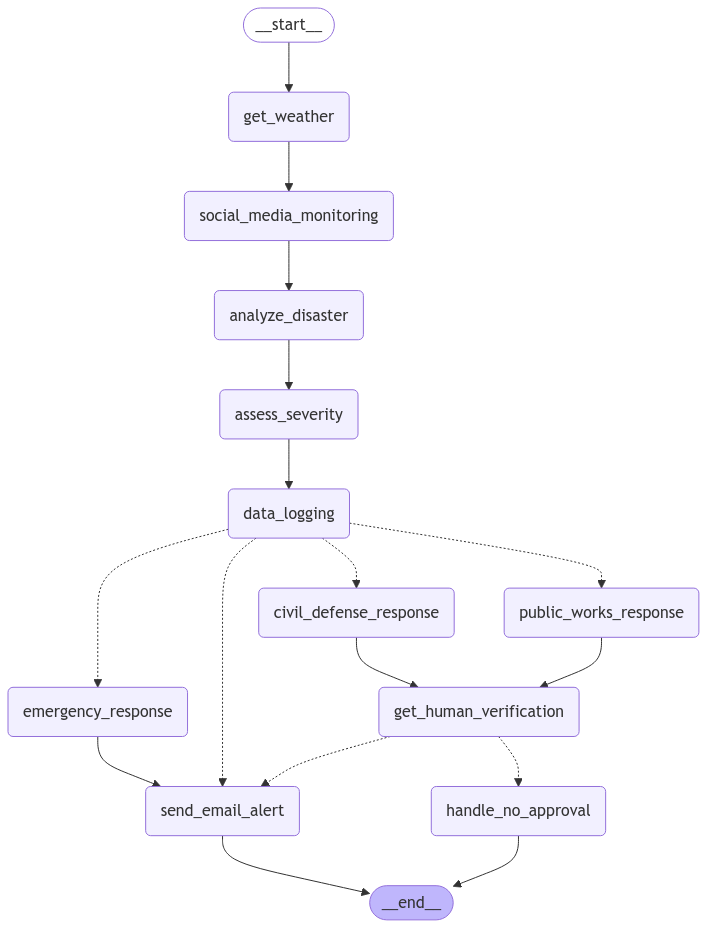

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass